In [2]:
# import numba as nb
import numpy as np
import pandas as pd
import scipy.stats as stats
import chaospy as cp
from pathlib import Path
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from econsa.morris import (
#     _shift_cov,
#     _shift_sample,
#     _uniform_to_standard_normal,
#     elementary_effects,
# )

# Harris Model from [Sensitivity analysis: A review of recent advances](https://www.sciencedirect.com/science/article/abs/pii/S0377221715005469)

Economic order quantity model, or Harris model, was developed by [Harris (1990)](https://doi.org/10.1287/opre.38.6.947), to solve the problem of firms determining the ideal order size for one year, considering inventory costs and ordering costs.

The model takes four variables, and determins the total ordering cost $T$:

$$T = \frac{1}{2\cdot 12R\cdot M}(CX + S) +\frac{S}{X} + C$$

- $M$ denotes the number of goods needed per month
- $C$ denotes the unit price of the good
- $X$ denotes the order size
- $S$ denotes the cost of placing an order (setup cost)

and $R$ is the interest and depreciation cost per month ($R=10$ in Harris (1990)), which we treat as an exogenous parameter. 

Therefore, $T$ is an function of $X$, and we can calculate the optimal order size $X^*$ by solving:

$$\begin{aligned}\min_{X} && T &= \frac{1}{2\cdot 12R\cdot M}(CX + S) +\frac{S}{X} + C \\
&& \frac{\partial T}{\partial X} &= \frac{C}{24R\cdot M} - \frac{S}{X^2} \overset{!}{=} 0 \\
&& X^* &= \sqrt{\frac{24R\cdot MS}{C}}\end{aligned}$$

$X^*$ is called economic order quantity(EOQ).

In sensitivity analysis, $X^*$ is denoted as $y$, the model output, and the model inputs are $M$, $C$ and $S$, denoted as $\mathbf{x}=(x_1,x_2,x_3)'$:

$$y = \sqrt{\frac{24r\cdot x_1 x_3}{x_2}}$$

We are interested in how $y$ changes depending on each $x_i$, in other words, the sensitivity of $y$ with regard to $x_i$.

## EOQ Function

In [13]:
def eoq_harris(params, x):
    """
    Economic order quantity model by Harris (1990),
    https://doi.org/10.1287/opre.38.6.947,
    as seen in Borgonovoa & Plischkeb (2016),
    https://doi.org/10.1016/j.ejor.2015.06.032
    
    Equation: y = sqrt(24*r*x1*x3 / x2),
    where r is interest & depreciation rate,
    and takes a value of 10 in both papers.
    
    Args: 
        params (np.array): 1d numpy array,
                           cuurrently only take the first param,
                           which is interest & depreciation rate, r=10.
        x (np.array or list): 2d numpy array with the independent variables,
                              currently only take the first 3 columns.
    Output:
        y (np.array): 1d numpy array with the dependent variables.
    """
    
    x_np = np.array(x)
    params_np = np.array(params)
    r = params_np.flatten()[0]
    
    y = np.zeros(x_np.T.shape[0])
    y = np.sqrt((24 * r * x_np[0] * x_np[2])/x_np[1])
    
    return(y)

In [74]:
# function for constructing fig. 4:

def eoq_harris_partial(params, x, fix_num=0):
    """
    Calculate the value of eoq_harris,
    fixing one x.
    
    Args: 
        params (np.array): 1d numpy array,
                           cuurrently only need the first param,
                           which is interest & depreciation rate, r=10.
        x (np.array or list): 2d numpy array with the independent variables,
                              currently only need the first 3 columns.
        fix_num (int): take value of 0~n-1.
    Output:
        y (np.array): 2d numpy array with the dependent variables,
                      keeping the fix_num-th x fixed.
    """
    
    x_np = np.array(x)
    r = params.flatten()[0]
    
    y = np.zeros(shape=(x_np.T.shape[0],x_np.T.shape[0]))
    
    if fix_num==0:
        for i,x_i in enumerate(x_np[fix_num]):
            y[i] = np.sqrt((24 * r * x_i * x_np[2])/x_np[1])
    elif fix_num==1:
        for i,x_i in enumerate(x_np[fix_num]):
            y[i] = np.sqrt((24 * r * x_np[0] * x_np[2])/x_i)
    elif fix_num==2:
        for i,x_i in enumerate(x_np[fix_num]):
            y[i] = np.sqrt((24 * r * x_np[0] * x_i)/x_np[1])
    return(y)

## Data Generation

In [9]:
# Set flags

seed = 1234
n = 10000

x_min_multiplier = 0.9
x_max_multiplier = 1.1
x0_1 = 1230
x0_2 = 0.0135
x0_3 = 2.15

In [10]:
params = np.zeros(shape=(1,1))
params[0,0] = 10

In [20]:
x_min_multiplier*x0_1, x_max_multiplier*x0_1

(1107.0, 1353.0)

### No Monte Carlo

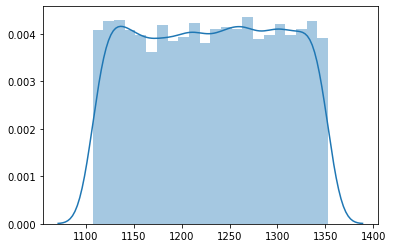

In [7]:
np.random.seed(seed)
x_1 = np.random.uniform(low=x_min_multiplier*x0_1,
                        high=x_max_multiplier*x0_1,
                        size=n)
x_2 = np.random.uniform(low=x_min_multiplier*x0_2,
                                  high=x_max_multiplier*x0_2,
                                  size=n)
x_3 = np.random.uniform(low=x_min_multiplier*x0_3,
                                  high=x_max_multiplier*x0_3,
                                  size=n)
plt.clf()
sns.distplot(x_1)

### Monte Carlo with `rvs`

In [98]:
np.random.seed(seed)
x_1 = stats.uniform(x_min_multiplier*x0_1,
                    x_max_multiplier*x0_1).rvs(10000)
x_2 = stats.uniform(x_min_multiplier*x0_2,
                    x_max_multiplier*x0_2).rvs(10000)
x_3 = stats.uniform(x_min_multiplier*x0_3,
                    x_max_multiplier*x0_3).rvs(10000)

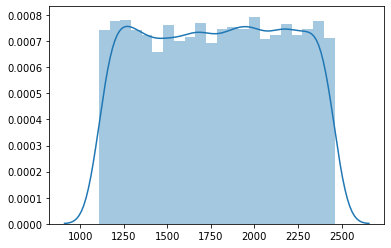

In [99]:
plt.clf()
sns.distplot(x_1)

In [100]:
x = np.array([x_1, x_2, x_3])

In [101]:
x

array([[1.36612582e+03, 1.94871317e+03, 1.69924563e+03, ...,
        1.30528321e+03, 2.06170341e+03, 2.24468833e+03],
       [2.27928193e-02, 2.06760836e-02, 2.21056353e-02, ...,
        2.67746942e-02, 2.68406133e-02, 2.42015290e-02],
       [3.24584710e+00, 2.36301353e+00, 2.82453599e+00, ...,
        2.22011337e+00, 2.72220416e+00, 3.40265933e+00]])

In [117]:
y0 = eoq_harris(params, [x0_1, x0_2, x0_3])
y0

6856.626964720579

In [115]:
np.array(x)

array([[1.36612582e+03, 1.94871317e+03, 1.69924563e+03, ...,
        1.30528321e+03, 2.06170341e+03, 2.24468833e+03],
       [2.27928193e-02, 2.06760836e-02, 2.21056353e-02, ...,
        2.67746942e-02, 2.68406133e-02, 2.42015290e-02],
       [3.24584710e+00, 2.36301353e+00, 2.82453599e+00, ...,
        2.22011337e+00, 2.72220416e+00, 3.40265933e+00]])

In [38]:
y = eoq_harris(params, x)

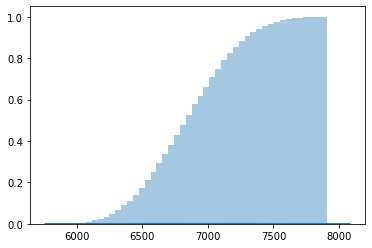

In [39]:
plt.clf()
sns.distplot(y, hist_kws=dict(cumulative=True))

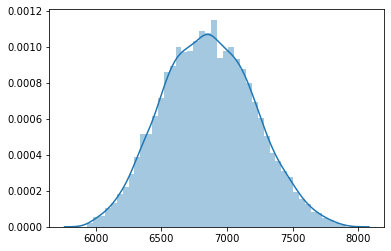

In [40]:
plt.clf()
sns.distplot(y)

### Monte Carlo with Chaospy (Closer to Borgonovoa & Plischkeb (2016))

In [8]:
sample_rule = "random"

In [9]:
np.random.seed(seed)
x_1 = cp.Uniform(x_min_multiplier*x0_1,
                 x_max_multiplier*x0_1).sample(n, rule=sample_rule)
x_2 = cp.Uniform(x_min_multiplier*x0_2,
                 x_max_multiplier*x0_2).sample(n, rule=sample_rule)
x_3 = cp.Uniform(x_min_multiplier*x0_3,
                 x_max_multiplier*x0_3).sample(n, rule=sample_rule)

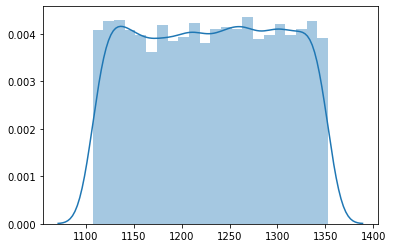

In [10]:
plt.clf()
sns.distplot(x_1)

In [11]:
x = np.array([x_1, x_2, x_3])
x

array([[1.15411378e+03, 1.26003876e+03, 1.21468102e+03, ...,
        1.14305149e+03, 1.28058244e+03, 1.31385242e+03],
       [1.40850581e-02, 1.37001970e-02, 1.39601155e-02, ...,
        1.48090353e-02, 1.48210206e-02, 1.43411871e-02],
       [2.17333584e+00, 2.01282064e+00, 2.09673382e+00, ...,
        1.98683879e+00, 2.07812803e+00, 2.20184715e+00]])

In [12]:
y = eoq_harris(params, x)

## Graphs

### Fig. 2

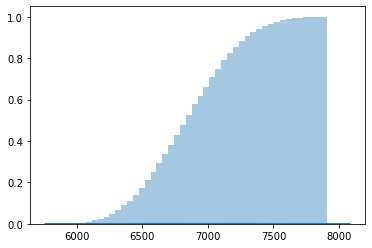

In [13]:
plt.clf()
sns.distplot(y, hist_kws=dict(cumulative=True))

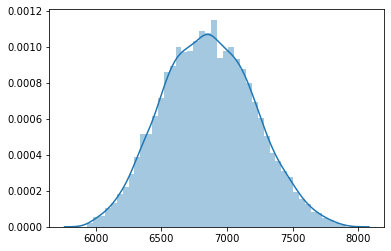

In [14]:
plt.clf()
sns.distplot(y)

### Fig. 3

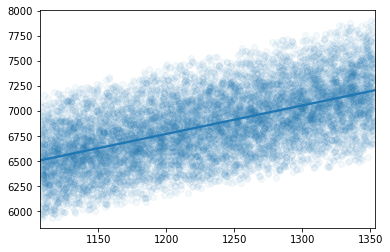

In [46]:
plt.clf()
sns.regplot(x=x[0], y=y,
            scatter_kws={"alpha":0.05})

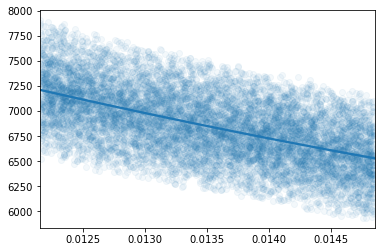

In [52]:
plt.clf()
sns.regplot(x=x[1], y=y, order=2,
            scatter_kws={"alpha":0.05})

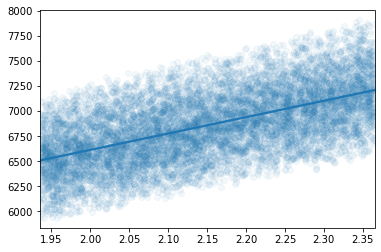

In [48]:
plt.clf()
sns.regplot(x=x[2], y=y,
            scatter_kws={"alpha":0.05})

### Fig. 4

In [67]:
y_fix_x_0 = eoq_harris_partial(params, x, fix_num=0)

In [69]:
y_fix_x_0.shape

(10000, 10000)

In [ ]:
# don't try at home:

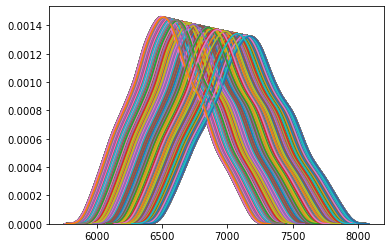

In [72]:
plt.clf()
# sns.set_palette(cubehelix)
for item in y_fix_x_0:
    sns.kdeplot(item)

## FIg.1 from Harris (1990)

This figure is using deterministic data, so we must use different data generation process for it.

### Data Generation

In [15]:
y = np.arange(300,5200,1)

In [16]:
x_1 = 1000
x_2 = 0.1
x_3 = 2

In [17]:
x = np.array([x_1, x_2, x_3])

In [53]:
def eoq_harris_total_cost(params, x, y):
    """
    Economic order quantity model by Harris (1990),
    https://doi.org/10.1287/opre.38.6.947,
    as seen in Borgonovoa & Plischkeb (2016),
    https://doi.org/10.1016/j.ejor.2015.06.032
    
    For plotting convenience, the total cost here excludes ordering cost,
    since it is assumed to be constant, as in Harris (1990).
    
    Args: 
        params (np.array): 1d numpy array,
                           cuurrently only take the first param,
                           which is interest & depreciation rate, r=10.
        x (np.array or list): 1d numpy array with the independent variables,
                              unis per month, unit cost, ordering cost.
        y (np.array): 1d numpy array, the size of order.
    Output:
        t (np.array): 1d numpy array, total cost according to each size.
    """
    
    x_np = np.array(x)
    params_np = np.array(params)
    r = params_np.flatten()[0]
    
    t = np.zeros(y.shape)
    
    t_setup = np.zeros(y.shape)
    t_setup = (1/y) * x[2]
    
    t_interest = np.zeros(y.shape)
    t_interest = 1/(24 * r * x[0]) * (y*x[1] + x[2])
    
    t = t_setup + t_interest
    
    return(t_setup, t_interest, t)

In [42]:
t_setup, t_interest, t = eoq_harris_total_cost(params, x, y)

### Plotting

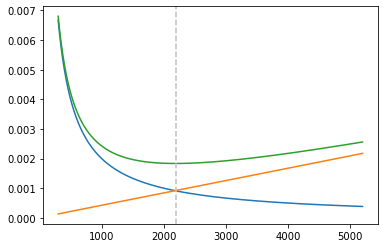

In [51]:
plt.clf()
sns.lineplot(x=y, y=t_setup)
sns.lineplot(x=y, y=t_interest)
sns.lineplot(x=y, y=t)
plt.axvline(2190, linestyle="--", color="silver")

# Replicating: [Introducing Copula in Monte Carlo Simulation](https://towardsdatascience.com/introducing-copula-in-monte-carlo-simulation-9ed1fe9f905)

## Random Variable Transformation

In [26]:
# Generate Monte Carlo sample

x = stats.uniform(0, 1).rvs(10000)

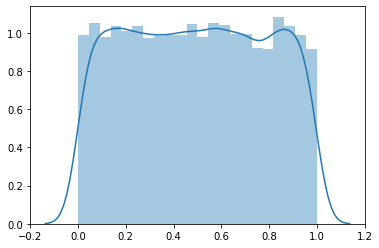

In [27]:
plt.clf()
sns.distplot(x)

In [28]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x)

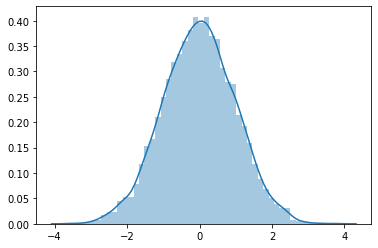

In [29]:
plt.clf()
sns.distplot(x_trans)

<Figure size 432x288 with 0 Axes>

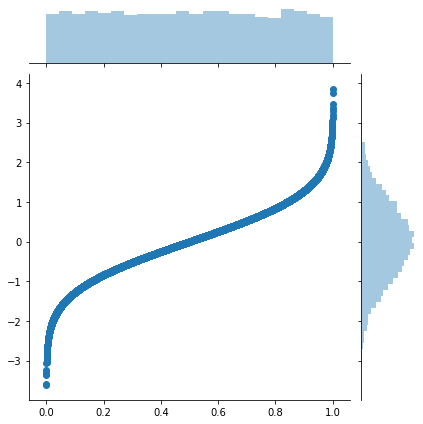

In [30]:
plt.clf()
sns.jointplot(x=x, y=x_trans)

## Gaussian Copula — Adding Variable Correlations

In [54]:
mvnorm = stats.multivariate_normal([0, 0], [[1., 0.5], [0.5, 1.]])
x = mvnorm.rvs((10000,))

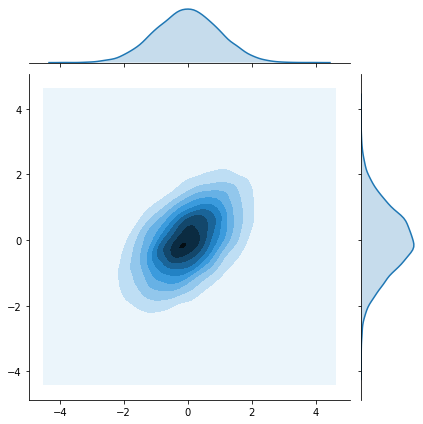

In [63]:
sns.jointplot(x=x[:,0], y=x[:,1], kind="kde")

In [64]:
norm = stats.norm([0],[1])
x_unif = norm.cdf(x)

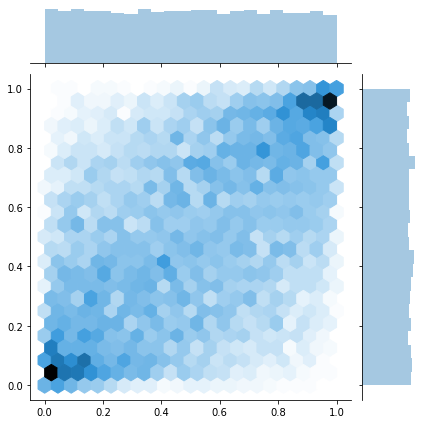

In [65]:
plt.clf()
sns.jointplot(x=x_unif[:,0], y=x_unif[:,1], kind="hex")

In [66]:
x1_tri  = stats.triang.ppf(x_unif[:, 0],  c=0.158 , loc=36, scale=21)
x2_norm =stats.norm(525, 112).ppf(x_unif[:, 1])

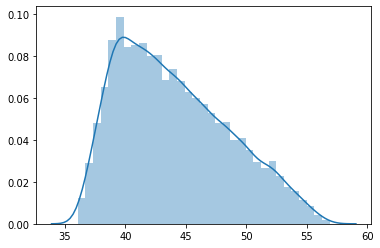

In [67]:
plt.clf()
sns.distplot(x1_tri)

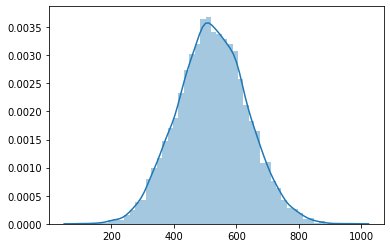

In [68]:
plt.clf()
sns.distplot(x2_norm)

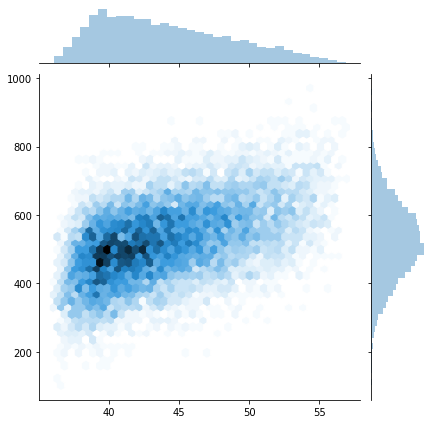

In [70]:
plt.clf()
sns.jointplot(x=x1_tri, y=x2_norm, kind="hex")

## Probabilistic Estimation of HCIIP

### No Variable Correlation Case

In [71]:
# HCIIP = GRV*NTG*POR*SHC/FVF

means = [0.]*5
cov = [[1., 0., 0., 0., 0.],
[0., 1., 0., 0., 0.],
[0., 0., 1., 0., 0.],
[0., 0., 0., 1., 0.],
[0., 0., 0., 0., 1.]]

mvnorm_std = stats.multivariate_normal(means,cov)
x = mvnorm_std.rvs(10000,random_state=42)
norm_std = stats.norm()
x_unif = norm_std.cdf(x)

#create individual distr.
grv = stats.triang(c=0.1 , loc=10000, scale=300).ppf(x_unif[:, 0])
ntg = stats.triang(c=0.2 , loc=0.5, scale=0.5).ppf(x_unif[:, 1])
phi = stats.truncnorm(-2*1.96,1.96,0.2,0.05).ppf(x_unif[:, 2])
shc = stats.norm(0.6,0.05).ppf(x_unif[:, 3])
fvf= stats.truncnorm(-1.96,2*1.96,1.3,0.1).ppf(x_unif[:, 4])

stoiip = 7758*grv*ntg*phi*shc/fvf/1e6

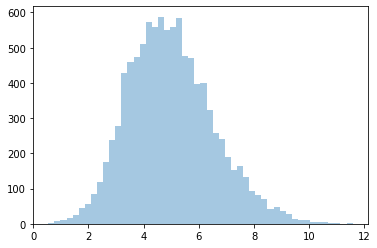

In [79]:
plt.clf()
sns.distplot(stoiip, kde=False)

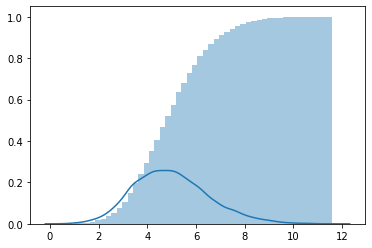

In [85]:
plt.clf()
sns.distplot(stoiip, hist_kws=dict(cumulative=True))

### Variable Correlation Case

In [86]:
means = [0.]*5

cov = [[1., 0., 0., 0., 0.],
[0., 1., 0.7, 0.6, 0.],
[0., 0.7, 1., 0.8, 0.],
[0., 0.6, 0.8, 1., 0.],
[0., 0., 0., 0., 1.]]

mvnorm_std = stats.multivariate_normal(means,cov)
x = mvnorm_std.rvs(10000,random_state=42)
norm_std = stats.norm()
x_unif = norm_std.cdf(x)

#create individual distr.
grv = stats.triang(c=0.1 , loc=10000, scale=300).ppf(x_unif[:, 0])
ntg = stats.triang(c=0.2 , loc=0.5, scale=0.5).ppf(x_unif[:, 1])
phi = stats.truncnorm(-2*1.96,1.96,0.2,0.05).ppf(x_unif[:, 2])
shc = stats.norm(0.6,0.05).ppf(x_unif[:, 3])
fvf= stats.truncnorm(-1.96,2*1.96,1.3,0.1).ppf(x_unif[:, 4])

stoiip = 7758*grv*ntg*phi*shc/fvf/1e6

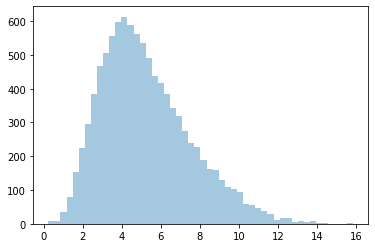

In [87]:
plt.clf()
sns.distplot(stoiip, kde=False)

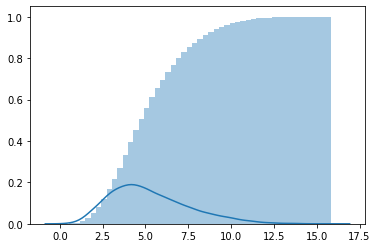

In [88]:
plt.clf()
sns.distplot(stoiip, hist_kws=dict(cumulative=True))

# Testing ChaosPy: [Distributions — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/index.html)

In [90]:
# to create a Gaussian random variable:
distribution = cp.Normal(mu=2, sigma=2)

In [91]:
# to create values from the probability density function:
t = np.linspace(-3, 3, 9)
distribution.pdf(t).round(3)

array([0.009, 0.021, 0.043, 0.078, 0.121, 0.164, 0.193, 0.198, 0.176])

In [93]:
# create values from the cumulative distribution function:
distribution.cdf(t).round(3)

array([0.006, 0.017, 0.04 , 0.085, 0.159, 0.266, 0.401, 0.55 , 0.691])

In [94]:
# To be able to perform any Monte Carlo method,
# each distribution contains random number generator:
distribution.sample(6).round(4)

array([3.1908, 1.5794, 2.1213, 0.3613, 2.2973, 2.5376])

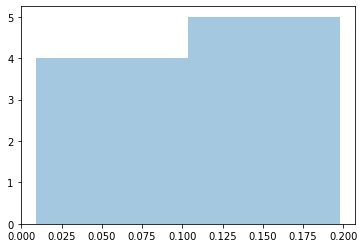

In [101]:
plt.clf()
sns.distplot(distribution.pdf(t).round(3), kde=False)

In [103]:
# to create low-discrepancy Hammersley sequences
# samples combined with antithetic variates:
distribution.sample(size=6, rule="halton", antithetic=True).round(4)

array([ 3.349 ,  0.651 , -0.3007,  4.3007,  2.6373,  1.3627])

## Moments: [Descriptive Statistics — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/descriptives.html#descriptives)

In [104]:
# the variance is defined as follows:
distribution.mom(2) - distribution.mom(1)**2

4.0

In [108]:
# or:
cp.Var(distribution)

array(4.)

## Seeding

In [112]:
np.random.seed(1234)
distribution.sample(5).round(4)

array([0.2554, 2.622 , 1.6865, 3.5808, 3.5442])

In [115]:
distribution.sample(5).round(4)

array([ 2.308 ,  2.0155, -2.4076,  3.4964,  4.3766])

## [Copulas — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/copulas.html)

In [134]:
np.random.seed(1234)
dist = cp.Iid(cp.Uniform(), 2)
copula = cp.Gumbel(dist, theta=1.5)

In [135]:
copula

Gumbel(Iid(Uniform(lower=0, upper=1), 2), theta=1.5)

In [136]:
np.random.seed(1234)
sample = copula.sample(10000)

<Figure size 432x288 with 0 Axes>

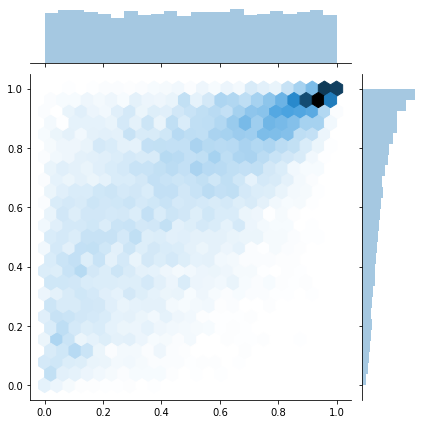

In [137]:
plt.clf()
sns.jointplot(x=sample[0], y=sample[1], kind="hex")

ok, what now…